# Finetuning Using Google Gemma's Model

In [1]:
!pip3 install -q -U bitsandbytes==0.42.0
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10
!pip3 install -q -U accelerate==0.27.1
!pip3 install -q -U datasets==2.17.0
!pip3 install -q -U transformers==4.38.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which is incompatible.
distributed 2024.1.1 requires dask==2024.1.1, but you have dask 2024.5.2 which is incompatible.
gcsfs 2024.3

In [3]:
import os
import transformers
import torch
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig, GemmaTokenizer

2024-06-30 16:16:57.532262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 16:16:57.532367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 16:16:57.744489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [33]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["HF_TOKEN"] = user_secrets.get_secret("HF_TOKEN")

### Prerequisites
* nf4(4-bit NormalFloat(NF4)) : https://www.kaggle.com/code/lorentzyeung/what-s-4-bit-quantization-how-does-it-help-llama2


In [5]:
model_id = "google/gemma-2b-it"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             device_map={"":0},
                                             token=os.environ['HF_TOKEN'])

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [7]:
text = "Instruction: classify this email as spam or not spam. Give output '0' if this is not spam and '1' if its spam. Email Text: Try this product worth $50 for FREE. Click this Link."
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Instruction: classify this email as spam or not spam. Give output '0' if this is not spam and '1' if its spam. Email Text: Try this product worth $50 for FREE. Click this Link.

Answer: 1

This is a spam email because it offers a product or service for free


In [8]:
text = "Instruction: classify this email as spam or not spam. Give output '0' if this is not spam and '1' if its spam. Email Text: Get a free iPhone 15 PRO by signing up!"
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Instruction: classify this email as spam or not spam. Give output '0' if this is not spam and '1' if its spam. Email Text: Get a free iPhone 15 PRO by signing up! 🎉🎉🎉

Answer: 1

This email is spam as it is an unsolicited promotional message


In [9]:
os.environ["WANDB_DISABLED"] = "false"

In [10]:
lora_config = LoraConfig(
    r = 8,
    target_modules = ["q_proj", "o_proj", "k_proj", "v_proj",
                      "gate_proj", "up_proj", "down_proj"],
    task_type = "CAUSAL_LM",
)

In [11]:
from datasets import load_dataset

data = load_dataset("legacy107/spamming-email-classification")
data = data.map(lambda samples: tokenizer(samples["Text"]), batched=True)

Generating train split:   0%|          | 0/4556 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/569 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/570 [00:00<?, ? examples/s]

Map:   0%|          | 0/4556 [00:00<?, ? examples/s]

Map:   0%|          | 0/569 [00:00<?, ? examples/s]

Map:   0%|          | 0/570 [00:00<?, ? examples/s]

In [14]:
data['train']['Text']

['Subject: aiesec polska - eurolds 2000  jarek ,  czy enron moze pomoc w organizacji tej imprezy ?  bylaby to dobra okazja nawiazania wielu pozytecznych kontaktow .  wicek  - - - - - - - - - - - - - - - - - - - - - - forwarded by vince j kaminski / hou / ect on 02 / 17 / 2000  08 : 51 am - - - - - - - - - - - - - - - - - - - - - - - - - - -  " andrzej wodnicki " on 02 / 16 / 2000 02 : 50 : 05 am  to : vince j kaminski / hou / ect @ ect  cc :  subject : aiesec polska - eurolds 2000  szanowny panie kaminski !  nazywam sie andrzej wodnicki i jestem czlonkiem stowarzysznia studentow  aiesec przy szkole glownej handlowej ( dawnej sgpis ) .  prosze o poswiecenie paru chwil na przeczytanie tego maila .  ( kontakt do pana otrzymalem od kolegi , ktory organizowal prezentacje firmy  enron na sgh , a posrednio od pana jarka astramowicza , przedstawiciela enron  na polske . )  w imieniu aiesec polska chcialbym zwrocic sie do pana z wielka prosba pomocy  przy wydarzeniu , ktore w tym roku organizuj

In [13]:
data['train']['Spam']

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,


In [15]:
def formatting_func(example):
    text = f"Instruction: classify this email as spam or not spam. Give output '0' if this is not spam and '1' if its spam. Email Text: {example['Text'][0]}\nOutput: {example['Spam'][0]}"
    return [text]

In [16]:
data['train']

Dataset({
    features: ['Text', 'Spam', 'input_ids', 'attention_mask'],
    num_rows: 4556
})

In [17]:
trainer = SFTTrainer(
    model=model,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=100,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    peft_config=lora_config,
    formatting_func=formatting_func,
)

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:223: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/4556 [00:00<?, ? examples/s]

Map:   0%|          | 0/570 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [18]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
1,5.120100
2,4.682400
3,4.452600
4,4.201400
5,3.765100
6,3.380200
7,3.071200
8,2.477800
9,2.527700
10,2.713200


TrainOutput(global_step=100, training_loss=0.6362188991298899, metrics={'train_runtime': 483.1906, 'train_samples_per_second': 0.828, 'train_steps_per_second': 0.207, 'total_flos': 1535354172211200.0, 'train_loss': 0.6362188991298899, 'epoch': 80.0})

In [27]:
new_model = "gemma-2b-it-fine-tune-email-spam" #Name of the model you will be pushing to huggingface model hub

In [28]:
trainer.model.save_pretrained(new_model)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
# Clear GPU memory before operations
torch.cuda.empty_cache()

In [31]:
from peft import PeftModel

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
merged_model= PeftModel.from_pretrained(base_model, new_model)
merged_model= merged_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
# Push the model and tokenizer to the Hugging Face Model Hub
merged_model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/JrX44/gemma-2b-it-fine-tune-email-spam/commit/a483bd49166f3706ad6d6e79273db3f9c32381a7', commit_message='Upload tokenizer', commit_description='', oid='a483bd49166f3706ad6d6e79273db3f9c32381a7', pr_url=None, pr_revision=None, pr_num=None)

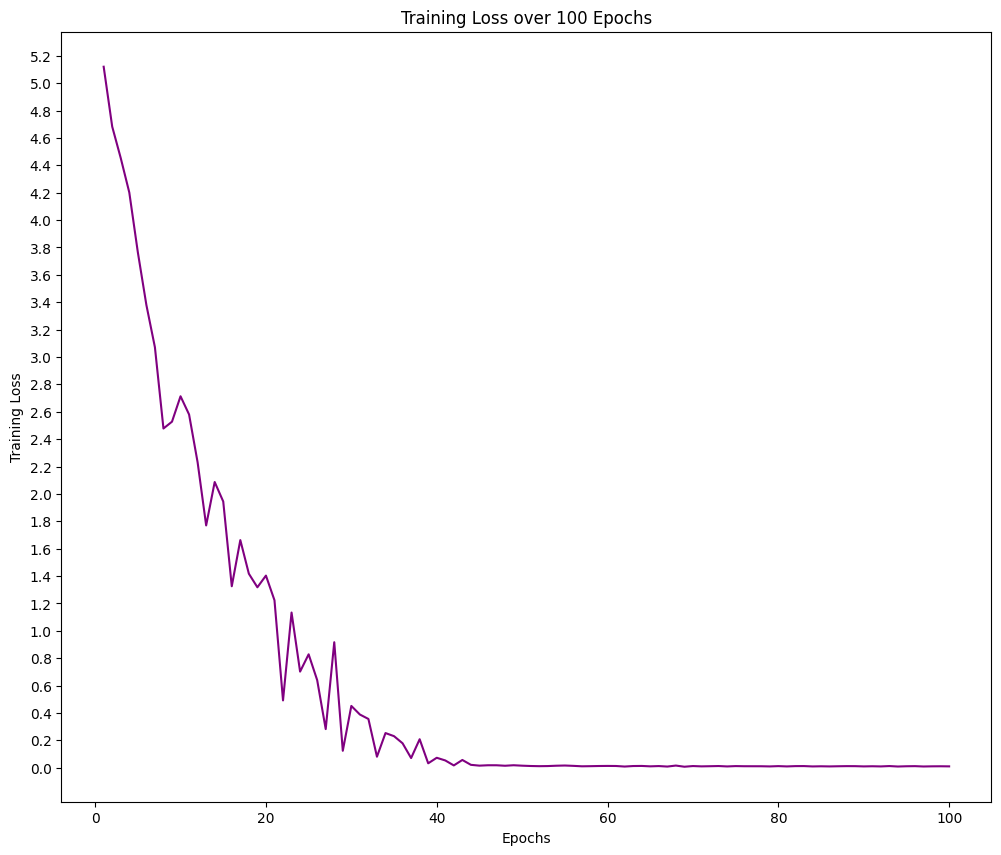

In [52]:
import matplotlib.pyplot as plt

# Define the steps and corresponding training loss values
steps = list(range(1, 101))
training_loss = [
    5.120100, 4.682400, 4.452600, 4.201400, 3.765100, 3.380200, 3.071200, 2.477800, 2.527700, 2.713200,
    2.580100, 2.230700, 1.770000, 2.086900, 1.944700, 1.325700, 1.662800, 1.417300, 1.318200, 1.403500,
    1.223400, 0.491900, 1.133700, 0.702300, 0.828600, 0.640200, 0.282500, 0.916900, 0.124100, 0.451600,
    0.388900, 0.356400, 0.080700, 0.253500, 0.230700, 0.178800, 0.070900, 0.208400, 0.032500, 0.073000,
    0.053400, 0.017100, 0.056900, 0.021400, 0.015500, 0.018300, 0.018200, 0.014700, 0.018400, 0.015200,
    0.012900, 0.011600, 0.012400, 0.014900, 0.016400, 0.013900, 0.010700, 0.011600, 0.012800, 0.013400,
    0.012900, 0.008900, 0.012600, 0.013300, 0.010400, 0.012400, 0.008800, 0.016000, 0.007600, 0.012500,
    0.010200, 0.011300, 0.012600, 0.009700, 0.012200, 0.011200, 0.011100, 0.011000, 0.009800, 0.012000,
    0.009800, 0.012000, 0.012300, 0.009700, 0.010800, 0.009800, 0.011000, 0.011900, 0.011700, 0.009900,
    0.011000, 0.009800, 0.012400, 0.009100, 0.011000, 0.011800, 0.009300, 0.010500, 0.010900, 0.010200
]

# Plot the data
plt.figure(figsize=(12, 10))
plt.plot(steps, training_loss, linestyle='-', color='purple')

# Add title and labels
plt.title('Training Loss over 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2])

# Show the plot
plt.grid(False)
plt.show()
